In [13]:
import matplotlib.pyplot as plt
from scipy import stats
from scipy import constants as c
import numpy.random as npr
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
%precision 4
npr.seed(123)

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

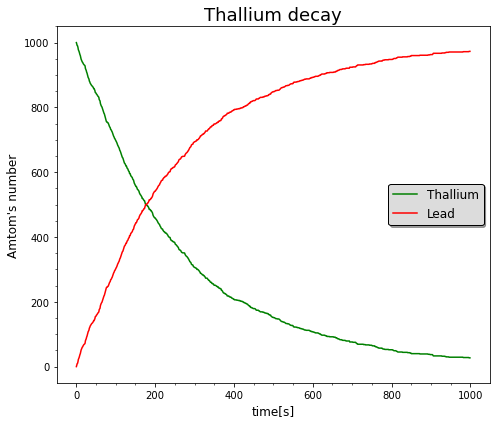

In [14]:
half_lieve = 3.052*60 # Converting in seconds


N_atoms = 1000

def prob(t):
    k = -t/half_lieve
    p = 1 - 2**k
    return p

Thallium_sample = np.empty(N_atoms)

time = range(0, 1000 ,1)
x = npr.random(1000)
for t in time:
    P = prob(t)
    y = (x > P)           
    Thallium_sample[t] = len(x[y])


lead_sample = np.ones(1000)*1000-Thallium_sample
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=(7, 6))
ax.plot(time, Thallium_sample, color = 'green',label = 'Thallium')
ax.plot(time, lead_sample, color = 'red', label = 'Lead')
ax.set_xlabel('time[s]', fontsize=12)
ax.set_ylabel('Amtom\'s number', fontsize=12)
ax.set_title('Thallium decay', fontsize=18)
ax.minorticks_on()
ax.legend(shadow=True, framealpha=1, facecolor='gainsboro', edgecolor='black', prop={'size':12})
fig.tight_layout()



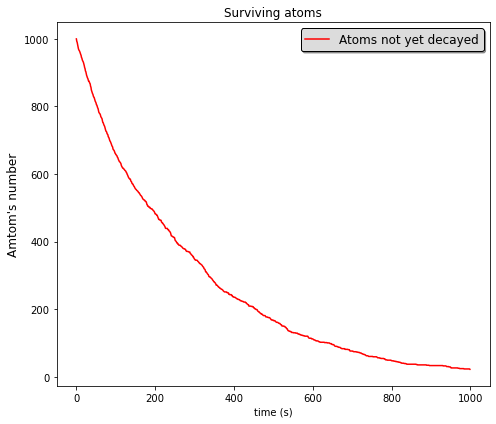

In [15]:
# Same exercise with the inverse transform method
def p(t):
    p = -half_lieve*np.log2(1-t)    #where t is a uniformly distributed RV in (0,1).
    return p

z = npr.random(1000)
T = p(z)
time = range(0, 1000, 1)
surviving = np.empty(1000)
for t in time:
    y = (T > t)
    surviving[t] = len(T[y])

fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=(7, 6))
ax.plot(time, surviving, color = 'red',label = 'Atoms not yet decayed')
ax.set_title('Surviving atoms')
ax.set_xlabel('time (s)')
ax.set_ylabel('Amtom\'s number', fontsize=12)
ax.legend(shadow=True, framealpha=1, facecolor='gainsboro', edgecolor='black', prop={'size':12})
fig.tight_layout()



2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

Fraction of bounced back particles 0.001575


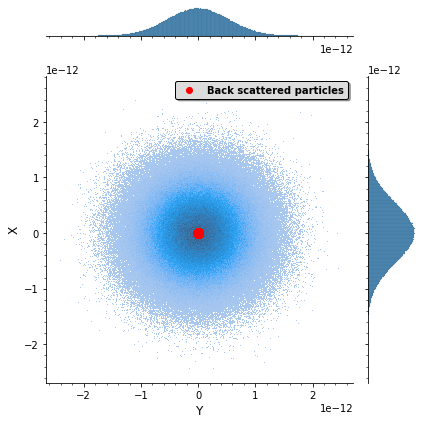

In [16]:
Z = 79
e = c.elementary_charge
epsilon0 = c.epsilon_0
#Going back to the SI
E = 7.7*10**6*c.e 

def scatter(b):
    t = Z*e**2/(2*c.pi*epsilon0*E*b)
    return t  #corresponding to tan(theta/2)

num_particles = 10**6
r0 = 4*c.pi*c.epsilon_0*c.hbar**2/(c.m_e*c.e**2)   
variance = np.array([(r0/100)**2, 0, 0, (r0/100)**2]).reshape(2,2)

b = np.random.multivariate_normal([0,0], variance, num_particles).T
data = pd.DataFrame({'x':b[0,:], 'y':b[1,:]})
sns_plot = sns.jointplot(data=data, x='x',y='y', kind="hist")

abs_b = np.sqrt(b[0]**2 + b[1]**2)
scatter_angles = scatter(abs_b)
mask = (scatter_angles > 1)
Backscatter = scatter_angles[mask]
b = b.T[mask].T
sns_plot.ax_joint.scatter(b[0,:], b[1,:], alpha=1, color = 'red', label = 'Back scattered particles')
legend=sns_plot.ax_joint.legend(prop={'weight':'bold','size':10}, loc='best', facecolor='gainsboro', edgecolor='black', shadow=True)
sns_plot.ax_joint.set_ylabel('X', fontsize=12)
sns_plot.ax_joint.set_xlabel('Y', fontsize=12)
sns_plot.ax_joint.minorticks_on()
sns_plot.fig.tight_layout()


fraction = len(Backscatter) / len(scatter_angles)
print('Fraction of bounced back particles', fraction)

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [17]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2

#Define integration:
N = 10**5
hit_counter = 0         
total = 0.         #mean value sum 
squares = 0. #sum for variance estimation (mv)
for i in range(N):
    x = npr.random()*2
    y = npr.random()
    total += f(x)
    squares += f(x)**2
    if y < f(x): hit_counter += 1
        
integral_hit_miss = 2*hit_counter/N
integral_mean_value = 2*total/N
   
p = hit_counter/N                         
sigma_hit_miss = 2*np.sqrt(N*p*(1-p))/N    

var = squares/N - (total/N)**2
sigma_mean_value = 2*np.sqrt(var/N)          

print('The integral with hit and miss method is : ', integral_hit_miss, '±', sigma_hit_miss)
print('Integral with mean value is:', integral_mean_value, '±', sigma_mean_value)
    

The integral with hit and miss method is :  1.44794 ± 0.0028272774119283027
Integral with mean value is: 1.4498130514202596 ± 0.0016724476705406903


**We see that the mean value metgthod is the one with the lesser error and that the two method differ, but considering the error yell a compatible result**

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [18]:
def f(x):                  
    r2 = np.sum(x**2)      
    if r2 <= 1: 
        return 1
    else: 
        return 0

N = 10**5

# In 2 dimensions...
x = npr.random(2*N).reshape(-1,2)
hit_counter = 0
for i in range(len(x)): 
    hit_counter += f(x[i])
d2_integral = 2**2 * hit_counter / N

#Dimention 10:
x = npr.random(10*N).reshape(-1,10)
hit_counter = 0
for i in range(len(x)): 
    hit_counter += f(x[i])
d10_integral = 2**10 *  hit_counter / N

print('The \'volume\' of a 2d sphere with the hit and miss method is:', d2_integral)
print('The volume of a 10d sphere with the hit and miss method is:', d10_integral)

The 'volume' of a 2d sphere with the hit and miss method is: 3.1466
The volume of a 10d sphere with the hit and miss method is: 2.68288


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [19]:
def w(x):
    return 1/(2*np.sqrt(x))

def f(x):
    return w(x)/(np.exp(x)+1)

N = 10**5
y = npr.random(N)**2.    

integral = 2./N * np.sum(f(y)/w(y))   
print('The estimated integral value is: ', integral)

The estimated integral value is:  0.8388284957827158
